In [1]:
%load_ext autoreload
%autoreload 2

from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time, shutil
import os
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'cosine', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

flags.DEFINE_string('dir_data', os.path.join('data', 'rcv1'), 'Directory to store data.')
flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')

# Data

**From Dropout (Bruna did the same).**
We took the dataset and split it into 63 classes based on the the 63 categories at the second-level of the category tree. We removed 11 categories that did not have any data and one category that had only 4 training examples. We also removed one category that covered a huge chunk (25%) of the examples. This left us with 50 classes and 402,738 documents. We divided the documents into equal-sized training and test sets randomly. Each document was represented
using the 2000 most frequent non-stopwords in the dataset.

In [3]:
# Fetch dataset from Scikit-learn.
dataset1 = utils.TextRCV1(data_home=FLAGS.dir_data)
dataset = utils.TextBeers()
# Pre-processing: transform everything to a-z and whitespace.
#print(train.show_document(1)[:400])
#train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
#train.vectorize(stop_words='english')
#print(train.show_document(1)[:400])

N = 804414 documents, C = 103 classes
10 10
N = 50000 documents, C = 10 classes


In [5]:
dataset.labels.shape

(50000,)

categories (2606875 assignments in total)
categories (976994 assignments in total)
  C11  :  24325 documents
  C12  :  11944 documents
  C13  :  37410 documents
  C14  :   7410 documents
  C16  :   1920 documents
  C17  :  42155 documents
  C18  :  52817 documents
  C21  :  25403 documents
  C22  :   6119 documents
  C23  :   2625 documents
  C24  :  32153 documents
  C31  :  40509 documents
  C32  :   2084 documents
  C33  :  15332 documents
  C34  :   4835 documents
  C41  :  11355 documents
  C42  :  11878 documents
  E11  :   8568 documents
  E12  :  27100 documents
  E13  :   6603 documents
  E14  :   2177 documents
  E21  :  43130 documents
  E31  :   2415 documents
  E41  :  17035 documents
  E51  :  21280 documents
  E61  :    391 documents
  E71  :   5268 documents
  G15  :  20672 documents
  GCRIM:  32219 documents
  GDEF :   8842 documents
  GDIP :  37739 documents
  GDIS :   8657 documents
  GENT :   3801 documents
  GENV :   6261 documents
  GFAS :    313 documents
  GHEA 

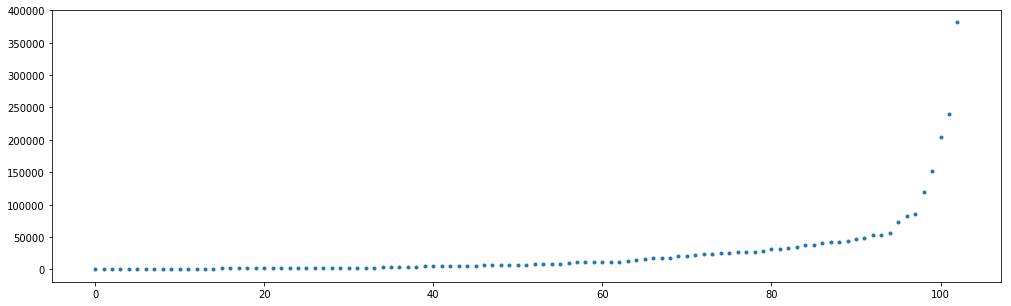

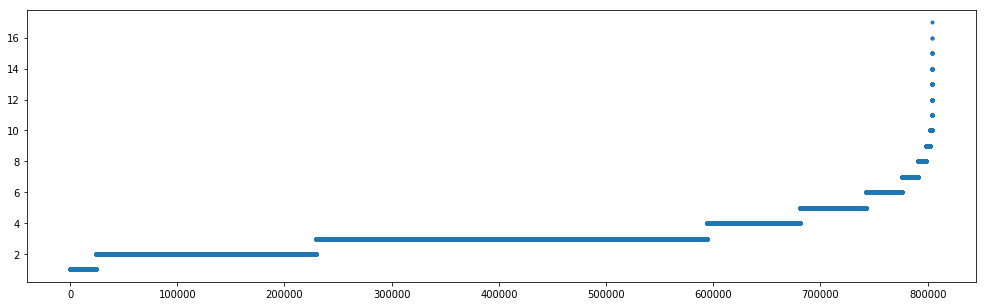

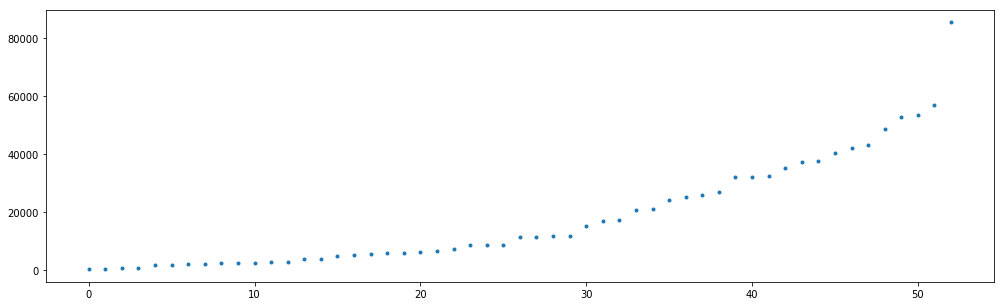

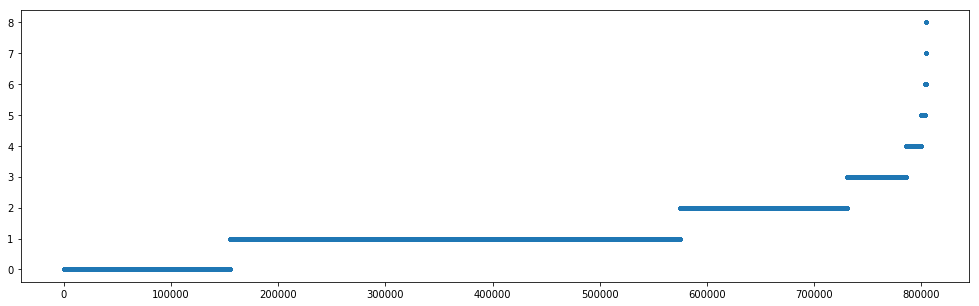

In [12]:
# Selection of classes.
keep = ['C11','C12','C13','C14','C15','C16','C17','C18','C21','C22','C23','C24',
        'C31','C32','C33','C34','C41','C42','E11','E12','E13','E14','E21','E31',
        'E41','E51','E61','E71','G15','GCRIM','GDEF','GDIP','GDIS','GENT','GENV',
        'GFAS','GHEA','GJOB','GMIL','GOBIT','GODD','GPOL','GPRO','GREL','GSCI',
        'GSPO','GTOUR','GVIO','GVOTE','GWEA','GWELF','M11','M12','M13','M14']
assert len(keep) == 55  # There is 55 second-level categories according to LYRL2004.
keep.remove('C15')   # 151785 documents
keep.remove('GMIL')  # 5 documents only

dataset.show_doc_per_class()
dataset.show_classes_per_doc()
dataset.remove_classes(keep)
dataset.show_doc_per_class(True)
dataset.show_classes_per_doc()

In [4]:
# Remove documents with multiple classes.
dataset.select_documents()
dataset.data_info()

AttributeError: 'TextBeers' object has no attribute 'select_documents'

In [6]:
# Remove short documents.
#train.data_info(True)
#wc = train.remove_short_documents(nwords=20, vocab='full')
#train.data_info()
#print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
#plt.figure(figsize=(17,5))
#plt.semilogy(wc, '.');

In [7]:
# Feature selection.
# Other options include: mutual information or document count.
#freq = train.keep_top_words(1000, 20)
#train.data_info()
#train.show_document(1)
#plt.figure(figsize=(17,5))
#plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
#wc = train.remove_short_documents(nwords=5, vocab='selected')
#train.data_info(True)

In [8]:
#dataset.normalize(norm='l1')
dataset.show_document(1000);

document 1000: label 3 --> 3, 106 words


In [10]:
# Word embedding
#if True:
#    train.embed()
#else:
#    train.embed('data_word2vec/GoogleNews-vectors-negative300.bin')
#train.data_info()
# Further feature selection. (TODO)

In [9]:
dataset.data.shape

(50000, 47130)

In [10]:
perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
Ntest = dataset.data.shape[0] // 2
perm_test = perm[:Ntest]
perm_train = perm[Ntest:]
train_data = dataset.data[perm_train,:].astype(np.float32)
test_data = dataset.data[perm_test,:].astype(np.float32)
train_labels = dataset.labels[perm_train]
test_labels = dataset.labels[perm_test]

if False:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = dataset.data.T.astype(np.float32)

#del dataset

In [11]:
dataset.labels

array([3, 6, 6, ..., 7, 8, 9])

In [14]:
from collections import Counter
Counter(dataset.labels)

Counter({0: 3,
         2: 250,
         3: 336,
         4: 1067,
         5: 1579,
         6: 4417,
         7: 8736,
         8: 18479,
         9: 11616,
         10: 3517})

# Feature graph

In [15]:
t_start = time.process_time()
dist, idx = graph.distance_lshforest(graph_data.astype(np.float64), k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist.astype(np.float32), idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edgx
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

677656 > 377040 edges
Layer 0: M_0 = |V| = 47130 nodes (0 added),|E| = 677656 edges
Execution time: 655.93s


In [11]:
assert FLAGS.coarsening_levels is 0
#t_start = time.process_time()
#train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
#test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
#print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#del perm

# Classification

In [12]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [13]:
if False:
    utils.baseline(train_data, train_labels, test_data, test_labels)

In [14]:
common = {}
common['dir_name']       = 'rcv1/'
common['num_epochs']     = 4
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 200
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [16]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: logits (softmax)
    representation: M_1 = 53
    weights: M_0 * M_1 = 47236 * 53 = 2503508
    biases: M_1 = 53
step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e+03, loss_average = 2.09e+01


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 83.85 (176103 / 210032), f1 (weighted): 83.39, loss: 2.23e+01
  time: 275s (wall 117s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e+03, loss_average = 1.83e+01
  validation accuracy: 84.47 (177412 / 210032), f1 (weighted): 83.85, loss: 2.05e+01
  time: 547s (wall 232s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e+03, loss_average = 2.17e+01
  validation accuracy: 85.99 (180612 / 210032), f1 (weighted): 85.76, loss: 1.81e+01
  time: 819s (wall 347s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e+03, loss_average = 2.17e+01
  validation accuracy: 85.10 (178747 / 210032), f1 (weighted): 85.11, loss: 2.01e+01
  time: 1092s (wall 464s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e+03, loss_average = 2.27e+01
  validation accuracy: 84.77 (178049 / 210032), f1 (weighted): 84.33, loss: 2.31e+01
  time: 1364s (wall 580s)
step 1200 / 8401 (epoch 0.57 / 4):
  learning_rate = 1.00e+03, loss_average = 1.50e+01
  validation acc

step 8401 / 8401 (epoch 4.00 / 4):
  learning_rate = 8.57e+02, loss_average = 6.87e+00
  validation accuracy: 87.28 (183306 / 210032), f1 (weighted): 87.78, loss: 1.75e+01
  time: 11589s (wall 4914s)
validation accuracy: peak = 89.07, mean = 88.09
train accuracy: 93.32 (196002 / 210033), f1 (weighted): 93.67, loss: 5.32e+00
time: 215s (wall 101s)
test  accuracy: 87.28 (183306 / 210032), f1 (weighted): 87.78, loss: 1.75e+01
time: 220s (wall 103s)


In [17]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47236
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 47236 * 2500 = 118090000
    biases: M_1 = 2500
  layer 2: logits (softmax)
    representation: M_2 = 53
    weights: M_1 * M_2 = 2500 * 53 = 132500
    biases: M_2 = 53
step 200 / 8401 (epoch 0.10 / 4):
  learning_rate = 1.00e-01, loss_average = 8.74e-01


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 79.99 (167996 / 210032), f1 (weighted): 77.11, loss: 8.76e-01
  time: 6988s (wall 1087s)
step 400 / 8401 (epoch 0.19 / 4):
  learning_rate = 1.00e-01, loss_average = 6.25e-01
  validation accuracy: 84.73 (177969 / 210032), f1 (weighted): 83.44, loss: 6.08e-01
  time: 14078s (wall 3188s)
step 600 / 8401 (epoch 0.29 / 4):
  learning_rate = 1.00e-01, loss_average = 5.53e-01
  validation accuracy: 87.00 (182719 / 210032), f1 (weighted): 86.05, loss: 5.10e-01
  time: 20954s (wall 4234s)
step 800 / 8401 (epoch 0.38 / 4):
  learning_rate = 1.00e-01, loss_average = 4.72e-01
  validation accuracy: 87.62 (184036 / 210032), f1 (weighted): 87.15, loss: 4.73e-01
  time: 27692s (wall 5230s)
step 1000 / 8401 (epoch 0.48 / 4):
  learning_rate = 1.00e-01, loss_average = 4.23e-01
  validation accuracy: 87.08 (182888 / 210032), f1 (weighted): 86.47, loss: 4.65e-01
  time: 34485s (wall 6279s)
step 1200 / 8401 (epoch 0.57 / 4):
  learning_rate = 1.00e-01, loss_average = 4.67e-01
  va

  validation accuracy: 90.78 (190667 / 210032), f1 (weighted): 90.62, loss: 3.27e-01
  time: 280689s (wall 46885s)
step 8401 / 8401 (epoch 4.00 / 4):
  learning_rate = 8.57e-02, loss_average = 2.03e-01
  validation accuracy: 90.69 (190486 / 210032), f1 (weighted): 90.52, loss: 3.31e-01
  time: 285507s (wall 47590s)
validation accuracy: peak = 91.10, mean = 90.68
train accuracy: 95.06 (199657 / 210033), f1 (weighted): 94.98, loss: 1.72e-01
time: 4779s (wall 690s)
test  accuracy: 90.69 (190486 / 210032), f1 (weighted): 90.52, loss: 3.31e-01
time: 4795s (wall 695s)


In [17]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47130
  layer 1: fc1
    representation: M_1 = 2500
    weights: M_0 * M_1 = 47130 * 2500 = 117825000
    biases: M_1 = 2500
  layer 2: fc2
    representation: M_2 = 500
    weights: M_1 * M_2 = 2500 * 500 = 1250000
    biases: M_2 = 500
  layer 3: logits (softmax)
    representation: M_3 = 11
    weights: M_2 * M_3 = 500 * 11 = 5500
    biases: M_3 = 11
step 200 / 1000 (epoch 0.80 / 4):
  learning_rate = 1.00e-01, loss_average = 1.52e+00


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 41.00 (10250 / 25000), f1 (weighted): 33.52, loss: 1.45e+00
  time: 2434s (wall 401s)
step 400 / 1000 (epoch 1.60 / 4):
  learning_rate = 9.50e-02, loss_average = 1.37e+00
  validation accuracy: 41.84 (10461 / 25000), f1 (weighted): 34.93, loss: 1.40e+00
  time: 4881s (wall 807s)
step 600 / 1000 (epoch 2.40 / 4):
  learning_rate = 9.03e-02, loss_average = 1.34e+00
  validation accuracy: 42.98 (10746 / 25000), f1 (weighted): 38.12, loss: 1.39e+00
  time: 7332s (wall 1214s)
step 800 / 1000 (epoch 3.20 / 4):
  learning_rate = 8.57e-02, loss_average = 1.22e+00
  validation accuracy: 43.27 (10818 / 25000), f1 (weighted): 39.73, loss: 1.38e+00
  time: 9783s (wall 1620s)
step 1000 / 1000 (epoch 4.00 / 4):
  learning_rate = 8.57e-02, loss_average = 1.24e+00
  validation accuracy: 41.98 (10495 / 25000), f1 (weighted): 36.31, loss: 1.45e+00
  time: 12232s (wall 2026s)
validation accuracy: peak = 43.27, mean = 42.22
train accuracy: 52.03 (13007 / 25000), f1 (weighted): 45.9

In [18]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [1]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47130
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 47130 * 1 / 1 = 47130
    weights: F_0 * F_1 * K_1 = 1 * 1 * 5 = 5
    biases: F_1 = 1
  layer 2: logits (softmax)
    representation: M_2 = 11
    weights: M_1 * M_2 = 47130 * 11 = 518430
    biases: M_2 = 11
step 200 / 1000 (epoch 0.80 / 4):
  learning_rate = 1.00e-01, loss_average = 3.67e+00


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 3.67e+00
  time: 2227s (wall 622s)
step 400 / 1000 (epoch 1.60 / 4):
  learning_rate = 9.99e-02, loss_average = 3.57e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 3.56e+00
  time: 4465s (wall 1245s)
step 600 / 1000 (epoch 2.40 / 4):
  learning_rate = 9.98e-02, loss_average = 3.47e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 3.48e+00
  time: 6717s (wall 1892s)
step 800 / 1000 (epoch 3.20 / 4):
  learning_rate = 9.97e-02, loss_average = 3.41e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 3.40e+00
  time: 9132s (wall 9886s)
step 1000 / 1000 (epoch 4.00 / 4):
  learning_rate = 9.97e-02, loss_average = 3.34e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 3.33e+00
  time: 11522s (wall 10879s)
validation accuracy: peak = 37.11, mean = 37.11
train accuracy: 36.81 (9202 / 25000), f1 (weighted): 19.81, l

In [15]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 47130
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 47130 * 5 / 1 = 235650
    weights: F_0 * F_1 * K_1 = 1 * 5 * 15 = 75
    biases: F_1 = 5
  layer 2: fc1
    representation: M_2 = 100
    weights: M_1 * M_2 = 235650 * 100 = 23565000
    biases: M_2 = 100
  layer 3: logits (softmax)
    representation: M_3 = 11
    weights: M_2 * M_3 = 100 * 11 = 1100
    biases: M_3 = 11
step 200 / 1000 (epoch 0.80 / 4):
  learning_rate = 1.00e-01, loss_average = 1.69e+00


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 1.67e+00
  time: 9852s (wall 2333s)
step 400 / 1000 (epoch 1.60 / 4):
  learning_rate = 9.99e-02, loss_average = 1.64e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 1.67e+00
  time: 19176s (wall 16490s)
step 600 / 1000 (epoch 2.40 / 4):
  learning_rate = 9.98e-02, loss_average = 1.64e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 1.67e+00
  time: 28335s (wall 18738s)
step 800 / 1000 (epoch 3.20 / 4):
  learning_rate = 9.97e-02, loss_average = 1.66e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 1.67e+00
  time: 37326s (wall 20936s)
step 1000 / 1000 (epoch 4.00 / 4):
  learning_rate = 9.97e-02, loss_average = 1.67e+00
  validation accuracy: 37.11 (9277 / 25000), f1 (weighted): 20.09, loss: 1.67e+00
  time: 46346s (wall 23143s)
validation accuracy: peak = 37.11, mean = 37.11
train accuracy: 36.81 (9202 / 25000), f1 (weighted): 1

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
37.11 36.81   20.09 19.81   1.67e+00 1.67e+00   23148   cgconv_fc_softmax


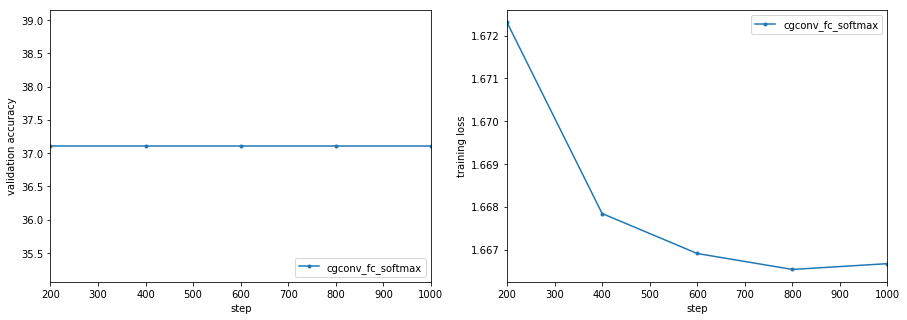

In [16]:
model_perf.show()